In [1]:
MODE = "OTHER"

# Basics
import numpy as np 
import pandas as pd
import warnings
import scipy as sc
import pandas_profiling
import sys
sys.path

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Serialization
from sklearn.externals import joblib 

# Preprocessing & sampling
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Machine Learning
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Database
import sqlite3
from sqlalchemy import create_engine

# Signal processing
import scipy.signal as signal
from scipy.signal import medfilt

# Progress bar
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Database
path_db = '/root/JaggerLewis/artificial_intelligence/DataBase/'
path_pkl = '/var/www/FlaskApp/FlaskApp/model/'

conn = sqlite3.connect(path_db + 'Database_jagger_lewis.db')
df = pd.read_sql_query("select * from Data_features_dogs;", conn)
df.drop_duplicates(inplace = True)

profile = pandas_profiling.ProfileReport(df)
rejected_variables = profile.get_rejected_variables(threshold=0.98)

if MODE == "TEST":
    file_txt = open(path_pkl + 'features_to_delete_' + MODE + '.txt', 'w')
else:
    file_txt = open(path_pkl + 'features_to_delete.txt', 'w')

for item in rejected_variables:
    file_txt.write("%s\n" % item)
    
file_txt.close()

df.drop(rejected_variables, axis = 1, inplace = True)

y_train = df.Behaviour
df_train =  df.drop(['Behaviour','index','Dogs'], axis = 1)

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_train)

if MODE == "TEST":
    joblib.dump(min_max_scaler, path_pkl + 'min_max_scaler_' + MODE + '.pkl')
else:
    joblib.dump(min_max_scaler, path_pkl + 'min_max_scaler.pkl')
    
df_normalized = pd.DataFrame(np_scaled)

df_normalized.colums = df_train.columns

In [2]:
def f(df_normalized, target, lowImport):
    
    datafile = 'low_Importance_' + str(lowImport) + '.txt'
    
    train = df_normalized.copy()
    train_labels = target
    fs = FeatureSelector(data = train, labels = train_labels)
    fs.identify_zero_importance(task = 'classification', eval_metric = None, n_iterations = 10, early_stopping = False)
    
    myfile = open(datafile,'w')
    
    fs.identify_low_importance(cumulative_importance = lowImport)
    low_importance_features = fs.ops['low_importance']
    print(low_importance_features[:5])
    
    list_no_importances = low_importance_features[:5]
    
    for v in list_no_importances:
        myfile.write("%s\n" % v)
    
    myfile.close()
    
    data_select = pd.DataFrame(train).drop(list_no_importances, axis = 1)
    
    return data_select

#df_normalized = f(df_normalized, y_train, 0.99)

In [3]:
#print(len(df_normalized.columns),y_train.unique(),df_normalized.shape,rejected_variables)

In [22]:
def cross_validate(model, dataframe, y, type_model = 'short'):
    '''
    Function to do the cross validation - using stacked Out of Bag method instead of averaging across folds.
    model = algorithm to validate. Must be scikit learn or scikit-learn like API 
    x = training data, numpy array
    y = training labels, numpy array
    folds = K, the number of folds to divide the data into
    repeats = Number of times to repeat validation process for more confidence
    '''
    
    y_input = y.copy()
    
    if type_model == 'short':
        folds = 3
        repeats = 3
    else:
        folds = 5
        repeats = 5
        type_model = 'long'
        
    ypred = np.zeros((len(y),repeats))
    ypred_1 = np.zeros((len(y),repeats))
    nb_class = len(pd.Series(y).unique())
    #ypred_prob = np.zeros((len(y),repeats*nb_class))
    ypred_prob = np.zeros((len(y),nb_class))
    score = np.zeros(repeats)
    index = np.array(dataframe.index)
    index_out = np.zeros((len(y),repeats))
    x = np.array(dataframe)
    
    for r in range(repeats):
        i = 0
        j = r
        x,y = shuffle(x, y, random_state = r) 
        index = shuffle(index, random_state = r)
        index_out[:,r] = index
        kf = StratifiedKFold(n_splits = folds, shuffle = False,  random_state = i + 1000)
        for train_ind, test_ind in kf.split(x, y):
            xtrain, ytrain = x[train_ind,:], y[train_ind]
            xtest, ytest = x[test_ind,:], y[test_ind]
            model.fit(xtrain, ytrain)
            print("Model", i, " &&&&&", j, "fitted")
            if MODE == "TEST":
                joblib.dump(model, path_pkl + 'model_TEST_' + type_model + '_' + str(i) + '_' + str(j) +'_.pkl') 
            else:
                joblib.dump(model, path_pkl + 'model_NEW_' + type_model + '_' + str(i) + '_' + str(j) +'_.pkl') 
            ypred[test_ind,r] = model.predict(xtest)
            if r == 0:
                ypred_prob[test_ind,(0):(nb_class)] = model.predict_proba(xtest) 
            if r > 0:
                ypred_prob[test_ind,(0):(nb_class)] = ypred_prob[test_ind,(0):(nb_class)] + model.predict_proba(xtest)
            i+= 1
            j+= 0
        #ypred_prob_out = pd.DataFrame(ypred_prob)
        #ypred_prob_out.columns = [ 1,  2,  3,  4, 10, 12, 13, 15, 16, 17, 18]
        #ypred_prob_out = ypred_prob_out.idxmax(axis=1)
        score[r] = accuracy_score(y,ypred[:,r])
        print("Accuracy:", round(accuracy_score(y,ypred[:,r])*100))
        #print("Accuracy with probabilities:", round(accuracy_score(y,ypred_prob_out)*100))
    print('Mean:',str(np.mean(score)))
    print('Deviation:',str(np.std(score)))
    
    ypred_prob = pd.DataFrame(ypred_prob)
    ypred_prob.columns = [ 1,  2,  3,  4, 10, 12, 13, 15, 16, 17, 18]
    return ypred, index_out.astype(int), np.mean(score), ypred_prob

def main_l1(train_input = df_train, rep = 5, regressor = lgb.LGBMClassifier(), type_model_l1 = 'short'):
    train = train_input.copy()
    y = np.array(y_train.apply(lambda x: float(x)))
    
    xgb_model = regressor
    out, index_out, score_output, ypred_prob = cross_validate(xgb_model, train, y, type_model = type_model_l1)
    
    return out, index_out.astype(int), score_output, ypred_prob

def deshuffled(output_stack_1, index_stack_1, j):
    for i in range(j):
        if i == 0:
            stack_1 = pd.DataFrame(output_stack_1[:,i], index=index_stack_1[:,i])
        if i > 0:
            stack_1 = stack_1.join(pd.DataFrame(output_stack_1[:,i], index=index_stack_1[:,i], columns = [i]))
    stack_1.sort_index(inplace = True)
    return stack_1

#stack_proba = pd.DataFrame(deshuffled(output_lgb, index_hist2, 3))

In [23]:
# Labelencoding
#df.replace('SeSecouer', 1, inplace = True)
#df.replace('Trotter', 2, inplace = True)
#df.replace('Immobile', 3, inplace = True)
#df.replace('Marcher', 4, inplace = True)
#df.replace('Renifler', 10, inplace = True)
#df.replace('SeGratter', 12, inplace = True)
#df.replace('SeLecher', 13, inplace = True)
#df.replace('Courir', 15, inplace = True)
#df.replace('Manger', 16, inplace = True)
#df.replace('Boire', 17, inplace = True)
#df.replace('Inconnu', 18, inplace = True)

In [24]:
# Models
output_lgb, index_hist2, score_1, ypred_prob  = main_l1(train_input = df_normalized, 
                                            regressor = lgb.LGBMClassifier(objective = 'multiclass', max_depth = 10, num_leaves = 75, learning_rate = 0.1, 
                                                                           n_jobs = -1, n_estimators = 1), rep = 3, 
                                            type_model_l1 = 'short')

stack_lgb = pd.DataFrame(deshuffled(output_lgb, index_hist2, 3))

('Model', 0, ' &&&&&', 0, 'fitted')
('Model', 1, ' &&&&&', 0, 'fitted')
('Model', 2, ' &&&&&', 0, 'fitted')
('Accuracy:', 69.0)
('Accuracy with probabilities:', 69.0)
('Model', 0, ' &&&&&', 1, 'fitted')
('Model', 1, ' &&&&&', 1, 'fitted')
('Model', 2, ' &&&&&', 1, 'fitted')
('Accuracy:', 69.0)
('Accuracy with probabilities:', 48.0)
('Model', 0, ' &&&&&', 2, 'fitted')
('Model', 1, ' &&&&&', 2, 'fitted')
('Model', 2, ' &&&&&', 2, 'fitted')
('Accuracy:', 69.0)
('Accuracy with probabilities:', 41.0)
('Mean:', '0.690268347882315')
('Deviation:', '0.0014429990231419599')


In [26]:
#print(output_lgb, ypred_prob)

In [27]:
#ypred_prob.idxmax(axis=1)

In [5]:
list_label = ['SeSecouer', 'Trotter', 'Immobile', 'Marcher', 'Renifler', 'SeGratter', 'SeLecher', 'Courir', 'Manger', 'Boire',
              'Inconnu']
list_num = [1, 2, 3, 4, 10, 12, 13, 15, 16, 17, 18]
list_str = ['1', '2', '3', '4', '10', '12', '13', '15', '16', '17', '18']

In [6]:
list_predict = []
stag = stack_lgb.transpose().apply(lambda x: x.value_counts())

for i in range(stag.shape[1]):
    list_predict.append(np.argmax(stag[i]))
    
for i in range(len(list_label)):
    y_train.replace(list_str[i], list_label[i], inplace = True)

prediction = pd.DataFrame(list_predict)[0].apply(int).apply(str)
prediction = prediction.apply(lambda x: str(x))

for i in range(len(list_label)):
    prediction.replace(list_str[i], list_label[i], inplace = True)    

In [7]:
y_train.replace(1, 'SeSecouer', inplace = True)
y_train.replace(2, 'Trotter', inplace = True)
y_train.replace(3, 'Immobile', inplace = True)
y_train.replace(4, 'Marcher', inplace = True)
y_train.replace(10, 'Renifler', inplace = True)
y_train.replace(12, 'SeGratter', inplace = True)
y_train.replace(13, 'SeLecher', inplace = True)
y_train.replace(15, 'Courir', inplace = True)
y_train.replace(16, 'Manger', inplace = True)
y_train.replace(17, 'Boire', inplace = True)
y_train.replace(18, 'Inconnu', inplace = True)

### Matrice de confusion

In [8]:
mat_con = confusion_matrix(y_train, prediction, labels = list_label)
df = pd.DataFrame(mat_con)
df.columns = list_label
df.index = list_label

sum_row = df.sum(axis = 1)

In [9]:
cm = mat_con.astype('float') / mat_con.sum(axis=1)[:, np.newaxis]
cm = cm*100

#The diagonal entries are the accuracies of each class
output = pd.DataFrame(list_label)
output.columns = ['Behaviours']
output['Accuracy'] = cm.diagonal()
output['Accuracy'] = output['Accuracy'].apply(lambda x: round(x))
output.values

array([['SeSecouer', 77.0],
       ['Trotter', 77.0],
       ['Immobile', 95.0],
       ['Marcher', 78.0],
       ['Renifler', 59.0],
       ['SeGratter', 68.0],
       ['SeLecher', 72.0],
       ['Courir', 85.0],
       ['Manger', 84.0],
       ['Boire', 72.0],
       ['Inconnu', 52.0]], dtype=object)

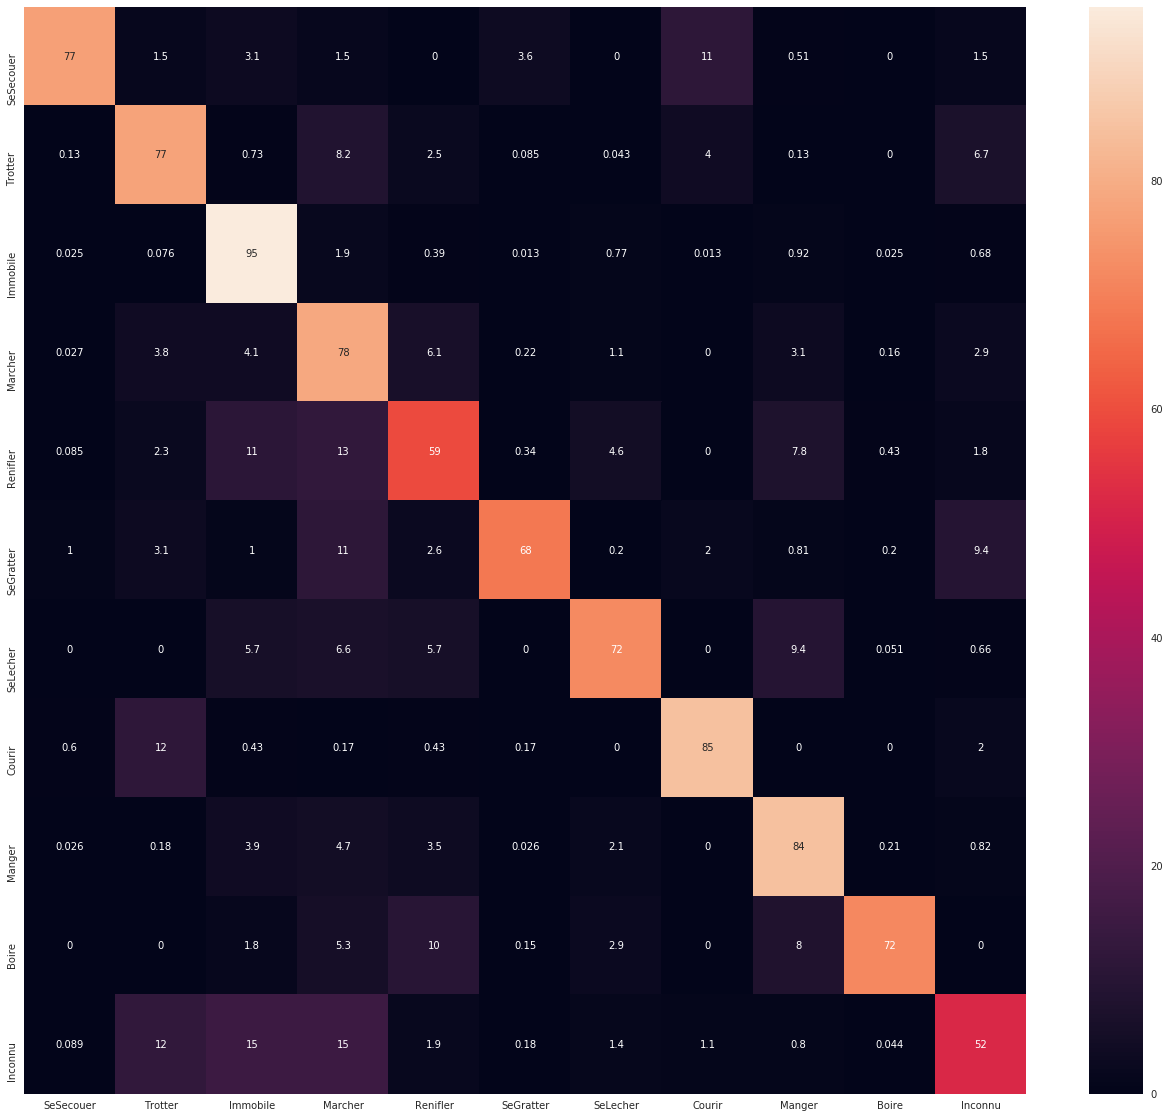

In [10]:
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(figsize = (20,20))
sns.heatmap(pd.DataFrame(cm, columns = df.columns, index = df.index), annot = True, annot_kws = {"size": 10})
plt.show()

In [11]:
# VP (vrais positifs) représente le nombre d'individus malades avec un test positif,
# FP (faux positifs) représente le nombre d'individus non malades avec un test positif,
# FN (faux négatifs) représente le nombre d'individus malades avec un test négatif,
# VN (vrais négatifs) représente le nombre d'individus non malades avec un test négatif.

cfm = pd.DataFrame(cm, columns = df.columns, index = df.index)

FP = cfm.sum(axis=0) - np.diag(cfm)  
FN = cfm.sum(axis=1) - np.diag(cfm)
TP = np.diag(cfm)
TN = cfm.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
# Probabilité de detecter le comportement 
#TPR = TP/(TP+FN)
TPR = pd.DataFrame(TP/(TP+FN))
TPR.columns = ["True_Positive_Rate"]

# Specificity or true negative rate
#TNR = TN/(TN+FP) 
TNR = pd.DataFrame(TN/(TN+FP))
TNR.columns = ["True_Negative_Rate"]

# Precision or positive predictive value
PPV = TP/(TP+FP)
PPV = pd.DataFrame(TP/(TP+FP))
PPV.columns = ["Precision - Positive_Predictive_value"]

# Negative predictive value
NPV = TN/(TN+FN)
NPV = pd.DataFrame(TN/(TN+FN))
NPV.columns = ["Negative_Predictive_value"]

# Fall out or false positive rate
FPR = FP/(FP+TN)
FPR = pd.DataFrame(FP/(FP+TN))
FPR.columns = ["Fall_out - False_Positve_Rate"]

# False negative rate
FNR = FN/(TP+FN)
FNR = pd.DataFrame(FN/(TP+FN))
FNR.columns = ["False_Negative_Rate"]

# False discovery rate
FDR = FP/(TP+FP)
FDR = pd.DataFrame(FP/(TP+FP))
FDR.columns = ["False_Discovery_Rate"]

# Overall accuracy
ACC = pd.DataFrame((TP+TN)/(TP+FP+FN+TN))
ACC.columns = ["Overall_Accuracy"]

stat = TPR.join(TNR).join(PPV).join(NPV).join(FPR).join(FNR).join(FDR).join(ACC)

stat.to_csv('/root/JaggerLewis/artificial_intelligence/Data/Stats.csv', sep = ';', index = True)

In [12]:
stat

True_Positive_Rate  True_Negative_Rate  \
SeSecouer            0.769231            0.997998   
Trotter              0.773794            0.965129   
Immobile             0.951880            0.953582   
Marcher              0.784844            0.932400   
Renifler             0.593350            0.966456   
SeGratter            0.682281            0.995228   
SeLecher             0.719755            0.986856   
Courir               0.846684            0.981550   
Manger               0.844878            0.968605   
Boire                0.715361            0.998876   
Inconnu              0.519929            0.973518   

           Precision - Positive_Predictive_value  Negative_Predictive_value  \
SeSecouer                               0.974636                   0.977399   
Trotter                                 0.689346                   0.977099   
Immobile                                0.672202                   0.994979   
Marcher                                 0.537253                   0.977445   
Renifler                                0.638843                   0.959623   
SeGratter                               0.934635                   0.969063   
SeLecher                                0.845583                   0.972386   
Courir                                  0.821075                   0.984620   
Manger                                  0.729081                   0.984237   
Boire                                   0.984535                   0.972294   
Inconnu                                 0.662545                   0.953005   

           Fall_out - False_Positve_Rate  False_Negative_Rate  \
SeSecouer                       0.002002             0.230769   
Trotter                         0.034871             0.226206   
Immobile                        0.046418             0.048120   
Marcher                         0.067600             0.215156   
Renifler                        0.033544             0.406650   
SeGratter                       0.004772             0.317719   
SeLecher                        0.013144             0.280245   
Courir                          0.018450             0.153316   
Manger                          0.031395             0.155122   
Boire                           0.001124             0.284639   
Inconnu                         0.026482             0.480071   

           False_Discovery_Rate  Overall_Accuracy  
SeSecouer              0.025364          0.977201  
Trotter                0.310654          0.947735  
Immobile               0.327798          0.953427  
Marcher                0.462747          0.918986  
Renifler               0.361157          0.932537  
SeGratter              0.065365          0.966779  
SeLecher               0.154417          0.962574  
Courir                 0.178925          0.969289  
Manger                 0.270919          0.957357  
Boire                  0.015465          0.973102  
Inconnu                0.337455          0.932283

### Matrice confusion inversée

In [13]:
mat_con_new = confusion_matrix(prediction, y_train, labels = list_label)
cm_new = mat_con_new.astype('float') / mat_con_new.sum(axis=1)[:, np.newaxis]
cm_new = cm_new*100
cm_new

#The diagonal entries are the accuracies of each class
output_new = pd.DataFrame(list_label)
output_new.columns = ['Behaviours']
output_new['test'] = cm_new.diagonal()
output_new['test'] = output_new['test'].apply(lambda x: round(x))
output_new.values

array([['SeSecouer', 87.0],
       ['Trotter', 74.0],
       ['Immobile', 88.0],
       ['Marcher', 68.0],
       ['Renifler', 67.0],
       ['SeGratter', 91.0],
       ['SeLecher', 80.0],
       ['Courir', 87.0],
       ['Manger', 84.0],
       ['Boire', 94.0],
       ['Inconnu', 71.0]], dtype=object)

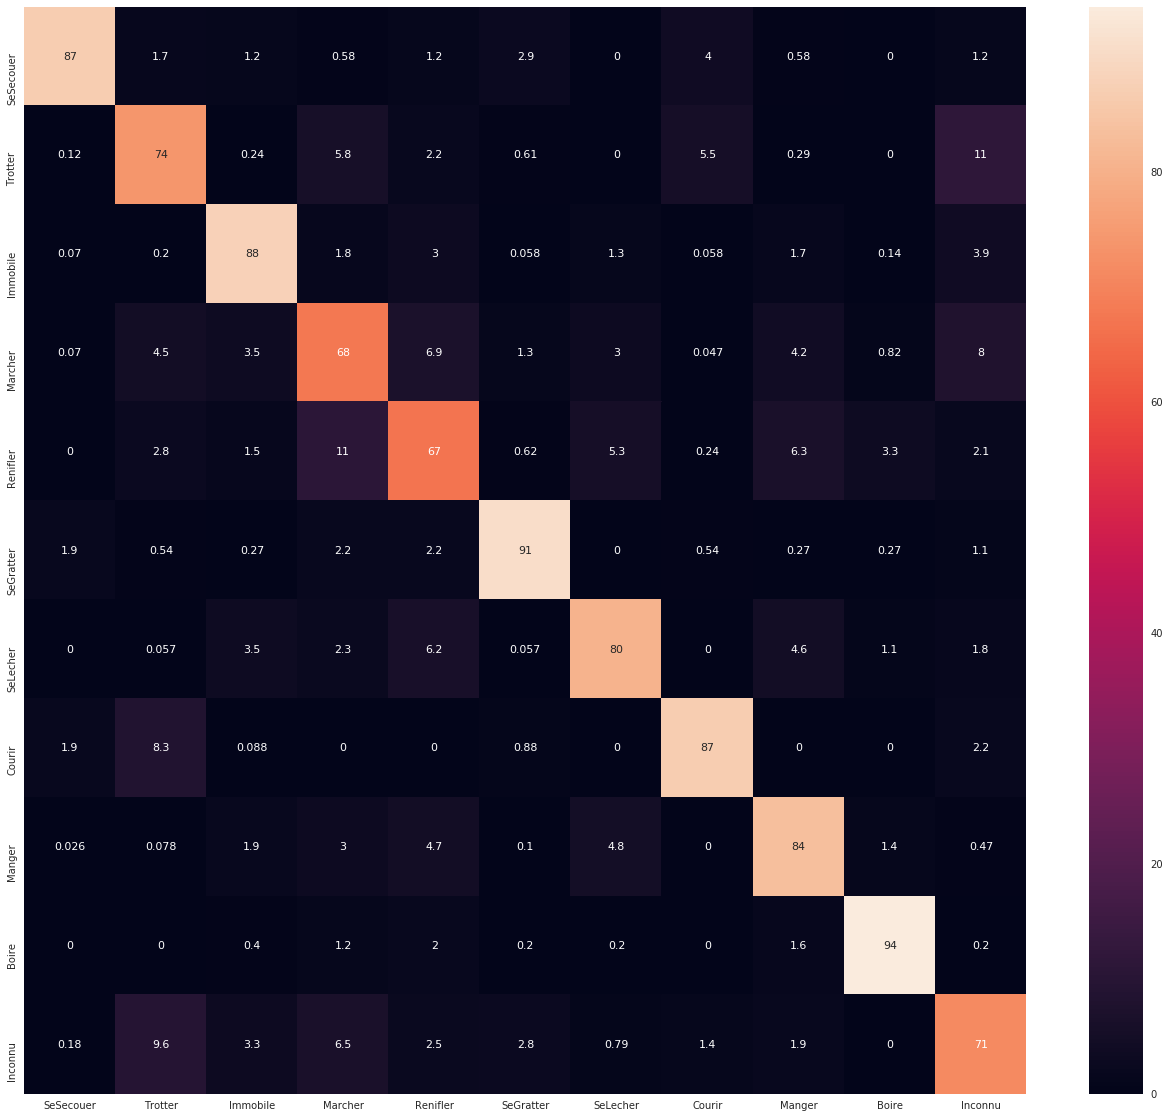

In [14]:
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(figsize = (20,20))
sns.heatmap(pd.DataFrame(cm_new, columns = df.columns, index = df.index), annot = True, annot_kws = {"size": 11})
plt.show()